In [144]:
# so do an xgboost or random forest and see which type of policy has the greatest impact
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings; warnings.simplefilter('ignore')

In [145]:
policy = pd.read_csv('policy_for_analysis.csv')
policy.drop(columns = ['Introduced by'], inplace =True)
policy.head()

,Date,Policy,Category,Deemed_sig_by_tracker
0,1/10/2020,Guidance published for health care providers o...,Infection prevention and control,1
1,1/10/2020,Guidance published for clinicians on the inves...,Health and social care settings,1
2,1/10/2020,Public Health England offers advice for travel...,Travel measures,0
3,1/16/2020,An interim recommendation is made to classify ...,Other,0
4,1/21/2020,Guidance published for primary care profession...,Health and social care settings,0


In [146]:
df = pd.read_csv('df_utla.csv')
df.drop(columns = ['Unnamed: 0'], inplace =True)
# drop my cruidly made Restrictions
df = df.drop(columns = 'Restrictions')

# daily per 100,000
df['case_rate_on_day'] = df['Daily_lab-confirmed_cases'] / (df['Population']/100000)

# add days since first infection
df['date'] = pd.to_datetime(df.date)
day_1 = min(df['date'].unique())
df['days_since_first'] = (df['date'] - day_1)
df['days_since_first'] = df['days_since_first'].astype(str)
df['days_since_first'] = df['days_since_first'].str.replace(' days', '')
df['days_since_first'] = df['days_since_first'].astype(int)

In [147]:
# want to display case rate for 2 weeks in the future as the current features will effect case rate 
# means I can't look at two most recent weeks as wont have case rates for it...
df['2_weeks_future_date'] = df['date'] + timedelta(days=14)
temp = df[['date', 'case_rate_on_day', 'Area_code']]
temp.rename(columns = {'case_rate_on_day':'case_rate_in_2_weeks', 'date':'date2'}, inplace = True)
df = pd.merge(df, temp, how='left', left_on=('2_weeks_future_date', 'Area_code'), right_on=('date2', 'Area_code'))

# df = shuffle(df)
# confirming that join was successful
# df[(df['date']== '2020-07-27') & (df['Area_name']=='Warwickshire')]
#df[(df['date']== '2020-08-10') & (df['Area_name']=='Warwickshire')]
# drop NA for case_rate_in_2_weeks Column
df = df[df['case_rate_in_2_weeks'].notna()]

In [148]:
# now need to add in policy info
# i think I will one hot encode to have a each unique date with policy totals based on category

# one hot encode
policy_encoded = pd.get_dummies(policy, columns = ['Category'], drop_first=True)
policy_encoded


# aggregate for date... i.e. each date will have a number of policies for each cat and num of sig policies for the day

policy_encoded = policy_encoded.groupby(by = 'Date').sum().reset_index()
policy_encoded

,Date,Deemed_sig_by_tracker,Category_Infection prevention and control,Category_Informing the public,Category_Legal change,"Category_Monitoring, Testing",Category_Non-health and social care settings,Category_Other,Category_SAGE papers,Category_Shielding measures,Category_Social distancing measures,"Category_Testing, surveillance and contact tracing",Category_Travel measures,Category_Vaccine
0,1/10/2020,2,1,0,0,0,0,0,0,0,0,0,1,0
1,1/16/2020,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1/21/2020,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/22/2020,1,0,0,0,0,0,0,0,0,0,1,0,0
4,1/28/2020,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,9/24/2020,1,0,0,0,0,0,0,0,0,1,1,0,0
144,9/28/2020,1,2,0,0,0,0,0,0,0,0,0,0,0
145,9/3/2020,0,0,0,0,0,0,0,0,0,0,1,0,0
146,9/7/2020,0,0,0,0,0,0,0,0,0,0,0,1,0


In [149]:
# merge policy with df

df = df.drop(columns = ['date2'])
policy_encoded['Date'] = pd.to_datetime(policy_encoded['Date'])
df = pd.merge(df, policy_encoded, how='left', left_on=('date'), right_on=('Date'))
df = df.drop(columns = ['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33503 entries, 0 to 33502
Data columns (total 26 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Area_name                                           33503 non-null  object        
 1   Area_code                                           33503 non-null  object        
 2   Area_type                                           33503 non-null  object        
 3   date                                                33503 non-null  datetime64[ns]
 4   Daily_lab-confirmed_cases                           33503 non-null  int64         
 5   ConfirmedCases                                      33503 non-null  int64         
 6   Cumulative_lab-confirmed_cases_rate                 33503 non-null  float64       
 7   id                                                  33503 non-null  int64         
 8   Popula

In [150]:
# fill na with zeros if have prefix Category columns and Deemed_sig_by_tracker

Cat_columns = df.filter(regex='^Category_',axis=1)
Cat_columns = Cat_columns.fillna(0)
df.filter(regex='^Category_',axis=1).fillna(0)

df.fillna(0, inplace=True)
df.isna().sum()

Area_name                                             0
Area_code                                             0
Area_type                                             0
date                                                  0
Daily_lab-confirmed_cases                             0
ConfirmedCases                                        0
Cumulative_lab-confirmed_cases_rate                   0
id                                                    0
Population                                            0
case_rate_on_day                                      0
days_since_first                                      0
2_weeks_future_date                                   0
case_rate_in_2_weeks                                  0
Deemed_sig_by_tracker                                 0
Category_Infection prevention and control             0
Category_Informing the public                         0
Category_Legal change                                 0
Category_Monitoring, Testing                    

In [151]:
df.to_csv('cases_analysis.csv')

In [152]:
df = pd.concat([df,pd.get_dummies(df['Area_name'], prefix='ps')],axis=1)

In [153]:
df = df.set_index(['date'])

In [154]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X


In [155]:
create_time_features(df)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2020-01-30,0,3,1,1,2020,30,30,5
2020-01-31,0,4,1,1,2020,31,31,5
2020-02-01,0,5,1,2,2020,32,1,5
2020-02-02,0,6,1,2,2020,33,2,5
2020-02-03,0,0,1,2,2020,34,3,6
...,...,...,...,...,...,...,...,...
2020-10-14,0,2,4,10,2020,288,14,42
2020-10-14,0,2,4,10,2020,288,14,42
2020-10-14,0,2,4,10,2020,288,14,42


In [156]:
my_sig = pd.read_csv('significant_policies.csv')
my_sig = my_sig[['Date', 'pct_change_between_now_and_two_weeks']]
my_sig.drop_duplicates(['Date'])

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
my_sig[['pct_change_between_now_and_two_weeks']] = scaling.fit_transform(my_sig[['pct_change_between_now_and_two_weeks']])
my_sig['Date'] = pd.to_datetime(my_sig['Date'])
my_sig

,Date,pct_change_between_now_and_two_weeks
0,2020-05-13,0.055409
1,2020-05-13,0.055409
2,2020-05-13,0.055409
3,2020-05-13,0.055409
4,2020-05-14,0.056828
...,...,...
62,2020-05-11,0.223884
63,2020-05-11,0.223884
64,2020-05-11,0.223884
65,2020-04-30,0.263212


In [157]:
df.drop("date", axis=1, inplace=True) #### maybe maybe not
df = df.reset_index()

df = pd.merge(df, my_sig, how='left', left_on='date', right_on='Date')
#df_main.drop('Date', inplace=True)



In [158]:
df.isnull().sum()
# replace nan with zero
df['pct_change_between_now_and_two_weeks'] = df['pct_change_between_now_and_two_weeks'].fillna(0)

In [159]:
df.drop(columns = ['Date'], inplace=True)

In [160]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39314 entries, 0 to 39313
Data columns (total 184 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   date                                                datetime64[ns]
 1   Area_name                                           object        
 2   Area_code                                           object        
 3   Area_type                                           object        
 4   Daily_lab-confirmed_cases                           int64         
 5   ConfirmedCases                                      int64         
 6   Cumulative_lab-confirmed_cases_rate                 float64       
 7   id                                                  int64         
 8   Population                                          float64       
 9   case_rate_on_day                                    float64       
 10  days_since_first     

In [161]:
df_main = df.copy()
# drop all non usable columns
df_main = df_main.loc[:,~df_main.columns.duplicated()]


df_main = df_main.drop(columns = ['date', 'Area_name', 'Area_code','Area_type','id','2_weeks_future_date'])
df_main

,Daily_lab-confirmed_cases,ConfirmedCases,Cumulative_lab-confirmed_cases_rate,Population,case_rate_on_day,days_since_first,case_rate_in_2_weeks,Deemed_sig_by_tracker,Category_Infection prevention and control,Category_Informing the public,...,ps_York,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pct_change_between_now_and_two_weeks
0,1,1,0.5,210618.0,0.474793,0,0.000000,1.0,0.0,0.0,...,1,0,3,1,1,2020,30,30,5,0.0
1,0,1,0.5,210618.0,0.000000,1,0.000000,0.0,0.0,0.0,...,1,0,4,1,1,2020,31,31,5,0.0
2,0,1,0.5,210618.0,0.000000,2,0.000000,0.0,0.0,1.0,...,1,0,5,1,2,2020,32,1,5,0.0
3,0,1,0.5,210618.0,0.000000,3,0.000000,1.0,0.0,1.0,...,1,0,6,1,2,2020,33,2,5,0.0
4,0,1,0.5,210618.0,0.000000,4,0.000000,0.0,0.0,0.0,...,1,0,0,1,2,2020,34,3,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39309,163,4698,1348.8,348312.0,46.797124,258,0.287099,1.0,0.0,0.0,...,0,0,2,4,10,2020,288,14,42,0.0
39310,64,3217,505.0,637070.0,10.045992,258,0.000000,1.0,0.0,0.0,...,0,0,2,4,10,2020,288,14,42,0.0
39311,192,6410,2703.4,237110.0,80.975075,258,0.421745,1.0,0.0,0.0,...,0,0,2,4,10,2020,288,14,42,0.0
39312,78,4611,508.0,907760.0,8.592580,258,0.220323,1.0,0.0,0.0,...,0,0,2,4,10,2020,288,14,42,0.0


In [162]:
#Check the datatypes, they need to all be int, float, or bool
df_main.dtypes.unique()

# there is an object .... needs to be removed
df_main.select_dtypes('object')
#it is the index and I believe can be ignored

""
0
1
2
3
4
...
39309
39310
39311
39312


In [163]:
# lastly drop some known correlated variabes
df_main.columns
df_main.drop(columns = ['ConfirmedCases', 'Daily_lab-confirmed_cases', 'Cumulative_lab-confirmed_cases_rate'], inplace = True)

In [164]:
# see all category columns
Cat_cols = [col for col in df_main.columns if 'Category' in col]
print(Cat_cols) #.... social distancting has a space in it.... not good! #trimmed in Excel

['Category_Infection prevention and control', 'Category_Informing the public', 'Category_Legal change', 'Category_Monitoring, Testing', 'Category_Non-health and social care settings', 'Category_Other', 'Category_SAGE papers', 'Category_Shielding measures', 'Category_Social distancing measures', 'Category_Testing, surveillance and contact tracing', 'Category_Travel measures', 'Category_Vaccine']


In [165]:

# how to train test split

from sklearn.model_selection import train_test_split
# first shuffle 
df_main = shuffle(df_main)


# then train test split 
features = df_main.drop('case_rate_in_2_weeks', axis=1)
labels = df_main['case_rate_in_2_weeks']


# model is built using x_train and y_train, will be assesed wirh X_test, y_test
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
# changed test size




#this splits into validation and test
#x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


# then do cross validation with train data 

In [166]:
x_train

,Population,case_rate_on_day,days_since_first,Deemed_sig_by_tracker,Category_Infection prevention and control,Category_Informing the public,Category_Legal change,"Category_Monitoring, Testing",Category_Non-health and social care settings,Category_Other,...,ps_York,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pct_change_between_now_and_two_weeks
6230,287942.0,10.766057,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,2,4,2020,105,14,16,0.000000
14878,185143.0,2.160492,113,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,4,2,5,2020,143,22,21,0.035971
35395,305842.0,3.596628,232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,4,3,9,2020,262,18,38,0.000000
6041,552858.0,7.235131,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,2,4,2020,104,13,16,0.000000
18268,288648.0,3.810870,128,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,5,2,6,2020,158,6,23,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26834,185143.0,0.540123,175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,3,3,7,2020,205,23,30,0.000000
22645,637070.0,0.784843,151,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,2,6,2020,181,29,27,0.958318
14333,179854.0,5.004059,113,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,4,2,5,2020,143,22,21,0.035971
17222,653537.0,2.295203,121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,5,2,5,2020,151,30,22,0.000000


In [167]:
#test to see if worked
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))
#so shows of data set train = 60%, validation is 20% and test is 20%
# we have ignored val for now as can see above

NameError: name 'y_val' is not defined

In [168]:
# xgb model

# try to do with sklearn in the future
import xgboost as xgb
from xgboost import plot_importance, plot_tree

reg = xgb.XGBRegressor(n_estimators=1000)

reg.fit(x_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

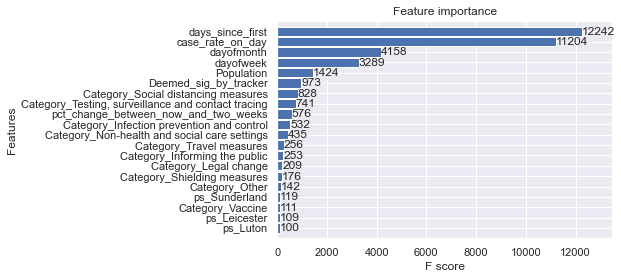

In [169]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

# really only one of these cases should be in here... 

In [407]:
# sklearns gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse)) # also a little worse, try switching out feature

The mean squared error (MSE) on test set: 21.4686


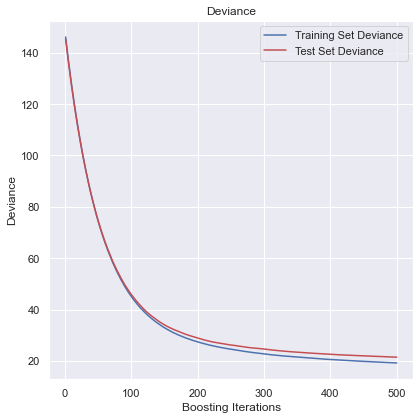

In [408]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [409]:
features = features.to_numpy()
labels = labels.to_numpy()

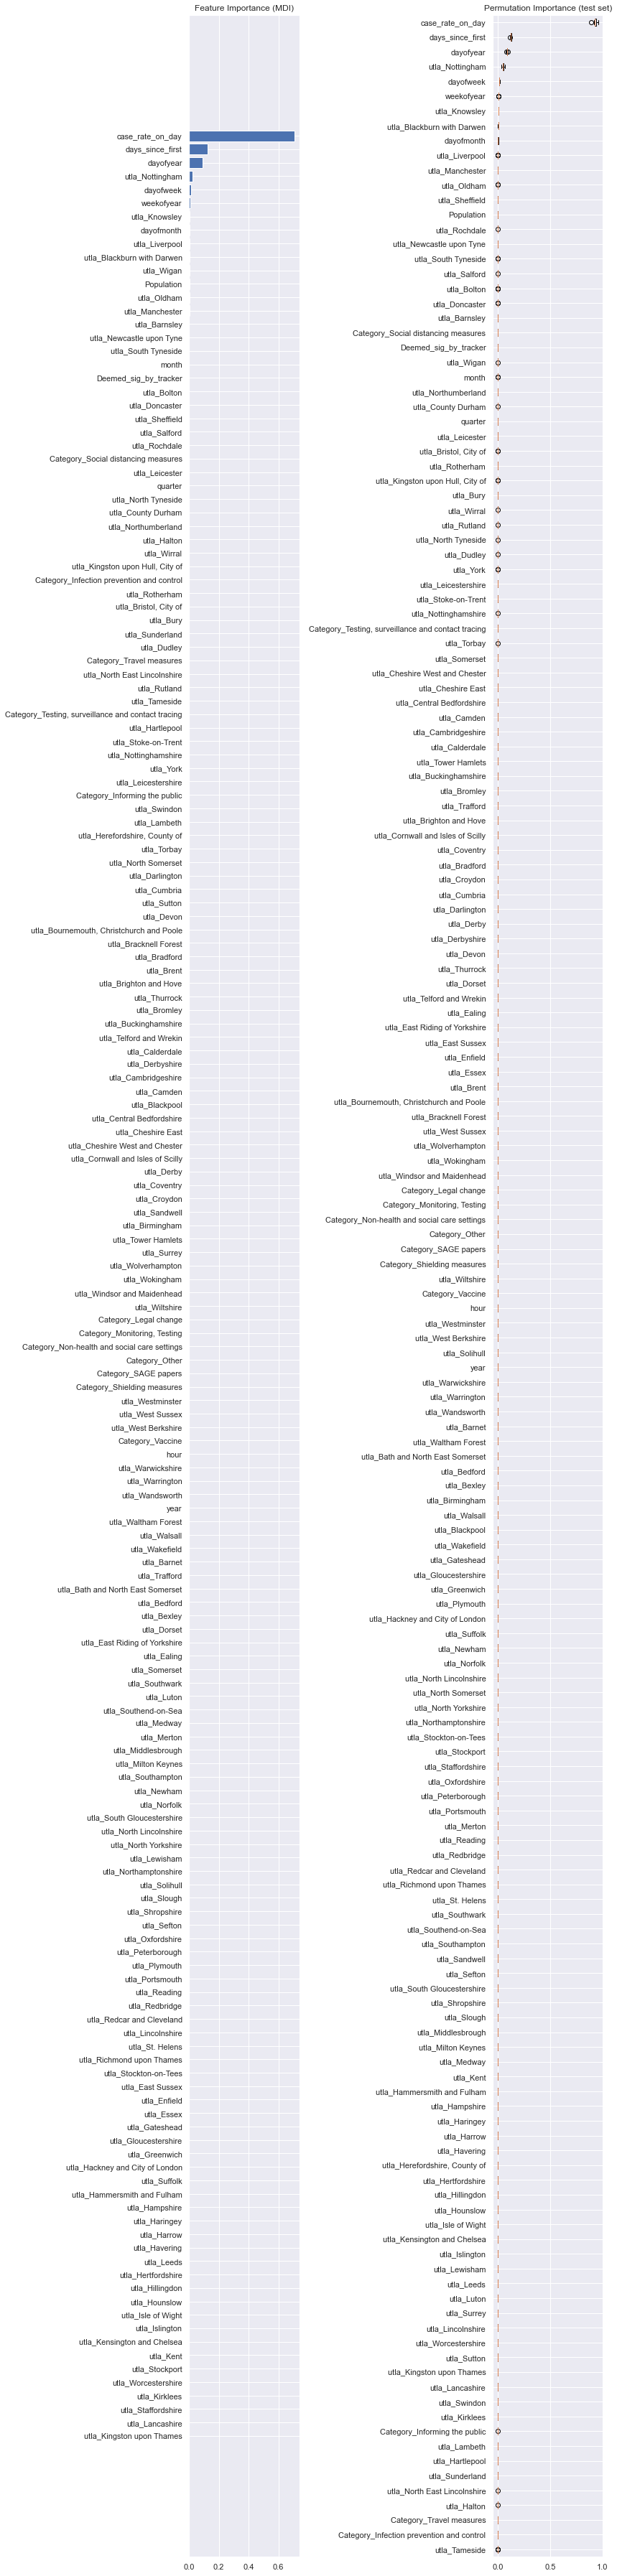

In [410]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 50))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(x_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [411]:
reg.score(x_test, y_test)

0.8545118136756448

In [412]:
# RMSLE 

np.sqrt(mean_squared_log_error(y_test, reg.predict(x_test)))

# ... not awful for data... kaggle top performers seem to produce 0.1 for worldwide dataset 

0.5147557115434985

In [ ]:
# can use the days case rate as a feature to predict in two weeks, maybe even case rate from several days prior


In [ ]:
# don't need to feature scale with decsion tree models

In [ ]:
#  could be good to look at percent change instead of daily rate 
# y_train = train.groupby(["Country/Region"]).Fatalities.pct_change(periods=1)